In [ ]:
! pip install opendatasets

In [ ]:
#==========================================
# import libraries
#==========================================

import warnings
warnings.filterwarnings('ignore')

import opendatasets as od
import os
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense,Dropout,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau

In [ ]:
#=============================================
# Step-2: Download Dataset
#=============================================


od.download('https://www.kaggle.com/datasets/paultimothymooney/breast-histopathology-images')

Skipping, found downloaded files in "./breast-histopathology-images" (use force=True to force download)


In [ ]:
#===========================================
# Create DataFrame
# ==========================================

base_dir='/content/breast-histopathology-images'

pattern=os.path.join(base_dir,'**','*.png')
filepaths=glob.glob(pattern,recursive=True)

label=[ os.path.basename(os.path.dirname(fp)) for fp in filepaths ]

df=pd.DataFrame({
    'label':label,
    'path':filepaths
})

train_df,val_test_df=train_test_split(df,test_size=0.2,random_state=42,stratify=df['label'])
val_df,test_df=train_test_split(val_test_df,test_size=0.5,random_state=42,stratify=val_test_df['label'])

print(train_df.shape)
print(test_df.shape)
print(val_df.shape)

(444038, 2)
(55505, 2)
(55505, 2)


In [ ]:
#-====================================================
# Data Augmentation + Normalization + Data Generator
##====================================================
BATCH_SIZE=16
IMG_SIZE=(50,50)
EPOCHS=5
SEED=42

Datagen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=True
)

val_test_datagen=ImageDataGenerator(
    rescale=1./255
)

# Train Generator

train_gen=Datagen.flow_from_dataframe(
    train_df,
    target_size=IMG_SIZE,
    x_col='path',
    y_col='label',
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=True,
    class_mode='binary'
)

# Val Generator

val_gen=val_test_datagen.flow_from_dataframe(
    val_df,
    target_size=IMG_SIZE,
    x_col='path',
    y_col='label',
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=False,
    class_mode='binary'
)

# Test Generator

test_gen=val_test_datagen.flow_from_dataframe(
    test_df,
    target_size=IMG_SIZE,
    x_col='path',
    y_col='label',
    shuffle=False,
    batch_size=BATCH_SIZE,
    seed=SEED,
    class_mode='binary'
)

Found 444038 validated image filenames belonging to 2 classes.
Found 55505 validated image filenames belonging to 2 classes.
Found 55505 validated image filenames belonging to 2 classes.


In [ ]:
#========================================
# Transfer Learning Model (ResNet50)
#========================================

base_model= ResNet50(weights='imagenet',include_top=False,input_shape=IMG_SIZE+(3,))
base_model.trainable=False

model=Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(1,activation='sigmoid')
])

In [ ]:
model.compile(
    optimizer=Adam(learning_rate= 1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
cb=[
    EarlyStopping(patience=3,restore_best_weights=True),
    ModelCheckpoint('best_model.h5',save_best_only=True)
]

In [ ]:
#-------------------------------
# Train Frozen Model(Baseline)
#-------------------------------

history=model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,
    callbacks=cb
)

Epoch 1/5
27752/27753 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7125 - loss: 0.5913

27753/27753 ━━━━━━━━━━━━━━━━━━━━ 1008s 36ms/step - accuracy: 0.7125 - loss: 0.5913 - val_accuracy: 0.7161 - val_loss: 0.5696
Epoch 2/5
27752/27753 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7164 - loss: 0.5733

27753/27753 ━━━━━━━━━━━━━━━━━━━━ 910s 33ms/step - accuracy: 0.7164 - loss: 0.5733 - val_accuracy: 0.7161 - val_loss: 0.5608
Epoch 3/5
27753/27753 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7172 - loss: 0.5697

27753/27753 ━━━━━━━━━━━━━━━━━━━━ 836s 30ms/step - accuracy: 0.7172 - loss: 0.5697 - val_accuracy: 0.7161 - val_loss: 0.5559
Epoch 4/5
27753/27753 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7162 - loss: 0.5679

27753/27753 ━━━━━━━━━━━━━━━━━━━━ 828s 29ms/step - accuracy: 0.7162 - loss: 0.5679 - val_accuracy: 0.7161 - val_loss: 0.5537
Epoch 5/5
27753/27753 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7182 - loss: 0.5661

27753/27753 ━━━━━━━━━━━━━━━━━━━━ 796s 29ms/step - accuracy: 0.7182 - loss: 0.5661 - val_accuracy: 0.7162 - val_loss: 0.5505


3470/3470 ━━━━━━━━━━━━━━━━━━━━ 46s 12ms/step - accuracy: 0.7263 - loss: 0.5563
Test Accuracy: 72.38%
3470/3470 ━━━━━━━━━━━━━━━━━━━━ 45s 12ms/step


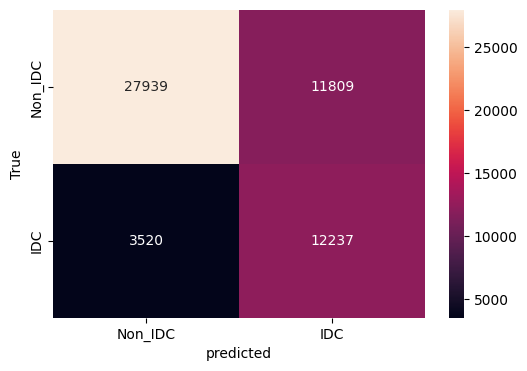

              precision    recall  f1-score   support

     Non_IDC       0.89      0.70      0.78     39748
         IDC       0.51      0.78      0.61     15757

    accuracy                           0.72     55505
   macro avg       0.70      0.74      0.70     55505
weighted avg       0.78      0.72      0.74     55505



In [ ]:
#----------------------------------
# Evaluation
#----------------------------------
loss,acc =model.evaluate(test_gen)
print(f'Test Accuracy: {acc*100:.2f}%')

# Confusion matrix
y_true=test_gen.classes
y_pred=(model.predict(test_gen)>0.5).astype('int32').flatten()

cm=confusion_matrix(y_true,y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm,annot=True,fmt='d',xticklabels=['Non_IDC','IDC'],yticklabels=['Non_IDC','IDC'])
plt.xlabel('predicted')
plt.ylabel('True')
plt.show()


 # classification report
print(classification_report(y_true,y_pred,target_names=['Non_IDC','IDC']))



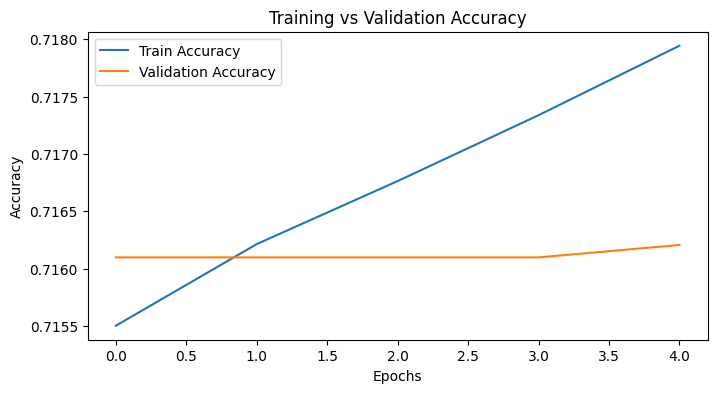

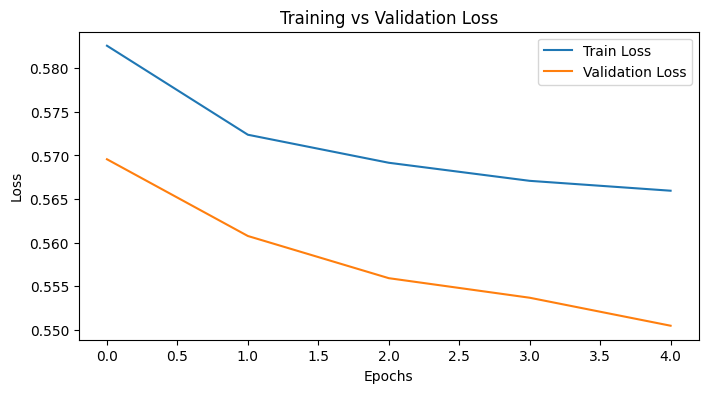

In [32]:
# Training & Validation Accuracy
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

# Training & Validation Loss
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

In [ ]:
#--------------------------------
# Base model Unfreeze
#---------------------------------

base_model.trainable=True

# fine-tune only last 50 layers

for layer in base_model.layers[:-50]:
  layer.trainable=False

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)




In [ ]:
cb=[
    EarlyStopping(patience=5,restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5,patience=3),
    ModelCheckpoint('fine_tuned_model.h5',save_best_only=True)
]

In [ ]:
h2=model.fit(
    train_gen,
    validation_data=val_gen,
    callbacks=cb,
    epochs=7
)

Epoch 1/7
27752/27753 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8008 - loss: 0.4492

27753/27753 ━━━━━━━━━━━━━━━━━━━━ 954s 34ms/step - accuracy: 0.8008 - loss: 0.4492 - val_accuracy: 0.4273 - val_loss: 1.2632 - learning_rate: 1.0000e-05
Epoch 2/7
27752/27753 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8230 - loss: 0.4066

27753/27753 ━━━━━━━━━━━━━━━━━━━━ 973s 34ms/step - accuracy: 0.8230 - loss: 0.4066 - val_accuracy: 0.7330 - val_loss: 1.1315 - learning_rate: 1.0000e-05
Epoch 3/7
27753/27753 ━━━━━━━━━━━━━━━━━━━━ 914s 33ms/step - accuracy: 0.8312 - loss: 0.3888 - val_accuracy: 0.4110 - val_loss: 1.5616 - learning_rate: 1.0000e-05
Epoch 4/7
27753/27753 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8340 - loss: 0.3837

27753/27753 ━━━━━━━━━━━━━━━━━━━━ 915s 33ms/step - accuracy: 0.8340 - loss: 0.3837 - val_accuracy: 0.8288 - val_loss: 0.5501 - learning_rate: 1.0000e-05
Epoch 5/7
27753/27753 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8379 - loss: 0.3763

27753/27753 ━━━━━━━━━━━━━━━━━━━━ 905s 33ms/step - accuracy: 0.8379 - loss: 0.3763 - val_accuracy: 0.7563 - val_loss: 0.5146 - learning_rate: 1.0000e-05
Epoch 6/7
27753/27753 ━━━━━━━━━━━━━━━━━━━━ 904s 33ms/step - accuracy: 0.8391 - loss: 0.3725 - val_accuracy: 0.7209 - val_loss: 0.7470 - learning_rate: 1.0000e-05
Epoch 7/7
27753/27753 ━━━━━━━━━━━━━━━━━━━━ 917s 33ms/step - accuracy: 0.8422 - loss: 0.3674 - val_accuracy: 0.6355 - val_loss: 1.0643 - learning_rate: 1.0000e-05


3470/3470 ━━━━━━━━━━━━━━━━━━━━ 91s 26ms/step - accuracy: 0.7591 - loss: 0.5129
Test Accuracy: 75.49%
3470/3470 ━━━━━━━━━━━━━━━━━━━━ 48s 12ms/step


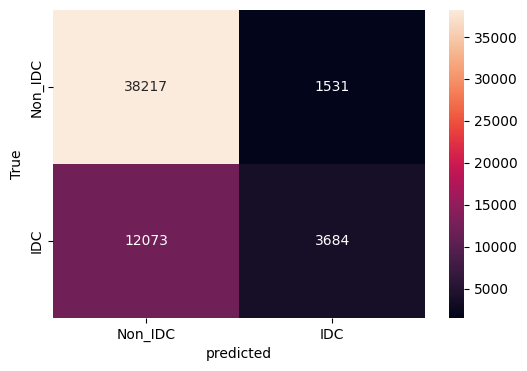

              precision    recall  f1-score   support

     Non_IDC       0.76      0.96      0.85     39748
         IDC       0.71      0.23      0.35     15757

    accuracy                           0.75     55505
   macro avg       0.73      0.60      0.60     55505
weighted avg       0.74      0.75      0.71     55505



In [29]:
# Evaluation
loss,acc =model.evaluate(test_gen)
print(f'Test Accuracy: {acc*100:.2f}%')

# Confusion matrix
y_true=test_gen.classes
y_pred=(model.predict(test_gen)>0.5).astype('int32').flatten()

cm=confusion_matrix(y_true,y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm,annot=True,fmt='d',xticklabels=['Non_IDC','IDC'],yticklabels=['Non_IDC','IDC'])
plt.xlabel('predicted')
plt.ylabel('True')
plt.show()


 # classification report
print(classification_report(y_true,y_pred,target_names=['Non_IDC','IDC']))




In [30]:
from sklearn.metrics import roc_auc_score

y_prob = model.predict(test_gen).ravel()
print("ROC-AUC:", roc_auc_score(y_true, y_prob))

3470/3470 ━━━━━━━━━━━━━━━━━━━━ 39s 11ms/step
ROC-AUC: 0.801355136809766


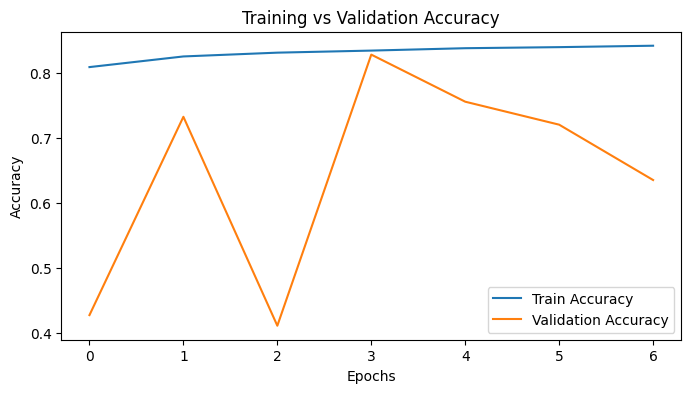

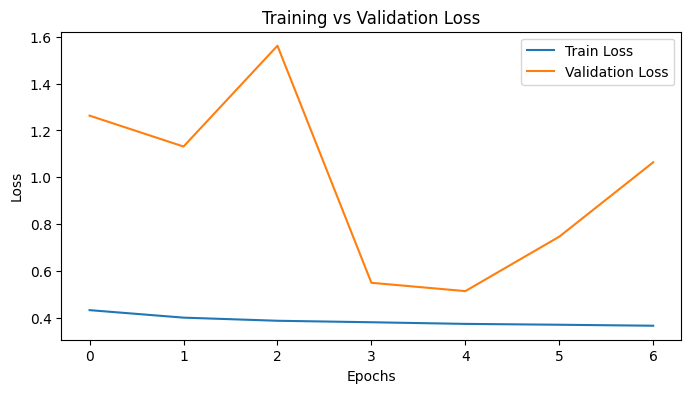

In [31]:
# Training & Validation Accuracy
plt.figure(figsize=(8,4))
plt.plot(h2.history['accuracy'], label='Train Accuracy')
plt.plot(h2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

# Training & Validation Loss
plt.figure(figsize=(8,4))
plt.plot(h2.history['loss'], label='Train Loss')
plt.plot(h2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()